In [1]:
# 日線量價吞噬前根紅Ｋ 進場
# RSI > 68 & KD > 80 或 紅Ｋ貫穿布林Ｍ往下 (第二條件實測發現吃掉大量停利空間)
# ! conda install -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import pytz
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
rate = 30
interval = '1d'
limit = 1000

# start epoch till now
start_time = 1609492611000
end_time = round(time.time() * 1000)

# step between timestamps in milliseconds, 60000 = 1min
step = 60000 * 3600

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)
    
    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [5]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

              Close_Time     Open    Close     High      Low        Volume
0    2021-01-03 07:59:59   728.91   774.56   787.69   714.91  1.352619e+06
1    2021-01-04 07:59:59   774.44   978.28  1011.07   768.71  2.813604e+06
2    2021-01-05 07:59:59   978.33  1041.43  1162.97   890.00  4.245011e+06
3    2021-01-06 07:59:59  1041.45  1099.56  1134.60   974.45  2.706996e+06
4    2021-01-07 07:59:59  1100.16  1208.42  1213.00  1057.26  2.390137e+06
..                   ...      ...      ...      ...      ...           ...
815  2023-03-29 07:59:59  1715.21  1772.99  1795.73  1701.13  5.365114e+05
816  2023-03-30 07:59:59  1773.00  1793.07  1827.99  1772.48  5.368656e+05
817  2023-03-31 07:59:59  1793.06  1793.61  1829.69  1763.00  5.796900e+05
818  2023-04-01 07:59:59  1793.60  1821.52  1847.28  1777.91  5.545255e+05
819  2023-04-02 07:59:59  1821.52  1823.35  1842.83  1819.61  6.654693e+04

[820 rows x 6 columns]


In [6]:
df = rawdf.copy()

In [7]:
def indicators(df):
# bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()
# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()
# kd
    kd_int = 14
    d_int = 3
    
    # Calculate Stochastic Oscillator
    kddf = pd.DataFrame()
    kddf[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kddf[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slowk'] = (df['Close'] - kddf[str(kd_int) + '-Low'])*100/(kddf[str(kd_int) + '-High'] - kddf[str(kd_int) + '-Low'])
    df['slowd'] = df['slowk'].rolling(d_int).mean()
    return df

In [8]:
indicators(df)

,Close_Time,Open,Close,High,Low,Volume,bb_u,bb_m,bb_l,rsi,slowk,slowd
0,2021-01-03 07:59:59,728.91,774.56,787.69,714.91,1.352619e+06,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-04 07:59:59,774.44,978.28,1011.07,768.71,2.813604e+06,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-05 07:59:59,978.33,1041.43,1162.97,890.00,4.245011e+06,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-06 07:59:59,1041.45,1099.56,1134.60,974.45,2.706996e+06,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-07 07:59:59,1100.16,1208.42,1213.00,1057.26,2.390137e+06,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
815,2023-03-29 07:59:59,1715.21,1772.99,1795.73,1701.13,5.365114e+05,1872.682770,1656.325333,1439.967897,56.478416,65.806792,59.880060
816,2023-03-30 07:59:59,1773.00,1793.07,1827.99,1772.48,5.368656e+05,1883.278004,1661.646000,1440.013996,57.854684,71.513023,59.886044
817,2023-03-31 07:59:59,1793.06,1793.61,1829.69,1763.00,5.796900e+05,1893.448258,1667.925333,1442.402409,57.893247,67.328158,68.215991
818,2023-04-01 07:59:59,1793.60,1821.52,1847.28,1777.91,5.545255e+05,1905.291632,1673.135333,1440.979035,59.933785,79.161551,72.667577


In [9]:
def conditions(df):

    # c1 日線收在下布林
    # c2 本Ｋ為綠Ｋ 前一天為紅Ｋ
    # c3 量大於前日
    # c4 收盤大於前日開盤 (discarded)
    # rsi > 45
    
    for index, row in df.iterrows():
        # c1
        df['c1'] = df['Close'] < df['bb_m']
        # c2
        df['c2'] = (df['Close'] - df['Open'] > 0) & (df['Close'].shift(1) - df['Open'].shift(1) < 0) 
        # c3
        df['c3'] = df['Volume'] > df['Volume'].shift(1)
        # c4
        df['c4'] = df['Close'] > df['Open'].shift(1)
        # c5
        df['c5'] = df['rsi'].shift(-1) >= 48

    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4 & df.c5 , 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True

In [10]:
conditions(df)

In [11]:
buydf = df.copy()

# 進出場

in_position = False
stop_loss = np.nan

for index, row in buydf.iterrows():

    tp_rsi = 68
    tp_slowk = 80
    tp_slowd = 80
    
    if index == 0:
        continue
        
        # set entry price (前一根Ｋ收盤價進場)
        # set stop loss (前一根Ｋ線低點停損)
        # 進場
    elif buydf.at[index, 'openbuy'] == True:
        close_val = buydf['Close']
        low_val = buydf['Low']
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = low_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = low_val.shift(1).at[index]
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and buydf.at[index, 'Close'] < stop_loss:
        buydf.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit （RSI > 68 & KD > 80）
    elif in_position == True and ((buydf.at[index, 'rsi'] >= tp_rsi) & (buydf.at[index, 'slowk'] >= tp_slowk) & (buydf.at[index, 'slowd'] >= tp_slowd)):
        buydf.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan
        
#     elif in_position == True and ((buydf.at[index, 'Close'] < buydf.at[index, 'bb_m']) & (buydf.at[index, 'Open'] > buydf.at[index, 'bb_m'])):
#         buydf.at[index, 'position'] = 'Sell'
#         in_position = False
#         stop_loss = np.nan

        
# 過濾有訊號或事件發生的Ｋ線
buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)


              Close_Time     Open    Close     High      Low        Volume  \
63   2021-03-07 07:59:59  1528.08  1650.35  1671.58  1513.03  1.013301e+06   
64   2021-03-08 07:59:59  1650.68  1726.16  1734.16  1630.35  8.484708e+05   
90   2021-04-03 07:59:59  1968.05  2133.69  2146.00  1948.48  8.461979e+05   
200  2021-07-22 07:59:59  1786.03  1995.50  2035.23  1747.55  1.115950e+06   
201  2021-07-23 07:59:59  1995.50  2024.56  2046.00  1947.62  7.688544e+05   
210  2021-08-01 07:59:59  2461.77  2531.05  2553.86  2420.68  5.076011e+05   
355  2021-12-24 07:59:59  3979.51  4111.41  4150.00  3893.23  3.802078e+05   
356  2021-12-25 07:59:59  4111.41  4046.36  4134.84  4017.17  2.308332e+05   
360  2021-12-29 07:59:59  4037.22  3792.75  4037.23  3759.36  3.580647e+05   
557  2022-07-14 07:59:59  1038.58  1115.00  1119.18  1006.32  2.035606e+06   
558  2022-07-15 07:59:59  1115.01  1193.42  1214.65  1072.11  1.605102e+06   
562  2022-07-19 07:59:59  1338.65  1581.04  1597.47  1336.07  2.

In [12]:
# 整理
def organize(df):
    df['Volume'] = round(df['Volume'], 2)
    df['bb_u'] = round(df['bb_u'], 2)
    df['bb_m'] = round(df['bb_m'], 2)
    df['bb_l'] = round(df['bb_l'], 2)
    df['rsi'] = round(df['rsi'], 2)
    df['slowk'] = round(df['slowk'], 2)
    df['slowd'] = round(df['slowd'], 2)

    return df

In [13]:
# 部位回測

organize(buydf)

posdf = buydf.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy') |
              (posdf['position'] == 'Sell') |
              (posdf['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'Volume', 'bb_u', 'bb_l', 'rsi', 'slowk', 'slowd', 'position','entry_p', 'stop_loss']
pos = posdf[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：RSI > 68 & KD > 80，出場價設定為該日收盤
        if pos.at[index, 'position'] == 'Sell':
            pos.at[index, 'exit_p'] = pos.at[index, 'Close'] * 1

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)

        
# 若最後一筆為 Buy，移除該單，迭代驗證，避免結算獲利錯誤
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break
    
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)

wins = pos['position'].str.count('Sell').sum()
loses = pos['position'].str.count('Stop').sum()
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}

result_df = pd.DataFrame(result)

print(result_df)



             Close_Time     Open    Close     High      Low      Volume  \
0   2021-03-08 07:59:59  1650.68  1726.16  1734.16  1630.35   848470.78   
1   2021-04-03 07:59:59  1968.05  2133.69  2146.00  1948.48   846197.93   
2   2021-07-23 07:59:59  1995.50  2024.56  2046.00  1947.62   768854.37   
3   2021-08-01 07:59:59  2461.77  2531.05  2553.86  2420.68   507601.05   
4   2021-12-25 07:59:59  4111.41  4046.36  4134.84  4017.17   230833.17   
5   2021-12-29 07:59:59  4037.22  3792.75  4037.23  3759.36   358064.72   
6   2022-07-15 07:59:59  1115.01  1193.42  1214.65  1072.11  1605101.93   
7   2022-07-19 07:59:59  1338.65  1581.04  1597.47  1336.07  2029918.77   
8   2022-10-18 07:59:59  1305.96  1331.40  1338.57  1295.64   459848.49   
9   2022-10-27 07:59:59  1459.74  1566.10  1594.99  1457.44  1236044.70   
10  2022-12-01 07:59:59  1216.49  1294.46  1309.77  1212.50   815679.27   
11  2023-01-11 07:59:59  1320.40  1335.62  1347.69  1316.80   459660.23   
12  2023-02-16 07:59:59  

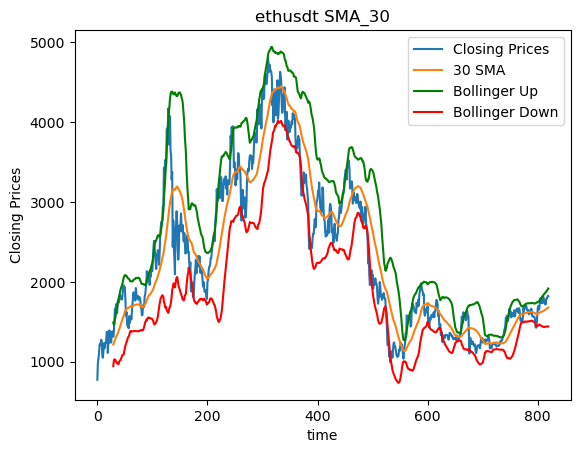

In [14]:
plt.title(symbol + ' SMA_' + str(rate))
plt.xlabel('time')
plt.ylabel('Closing Prices')
plt.plot(df.Close, label='Closing Prices')
plt.plot(df.bb_m, label= str(rate) + ' SMA')
plt.plot(df.bb_u, label='Bollinger Up', c='g')
plt.plot(df.bb_l, label='Bollinger Down', c='r')
plt.legend()
plt.show()